In [1]:
"""
Created on Wed Jan 10 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings

from gseapy import Msigdb
import decoupler as dc
import gseapy as gp
from gseapy import barplot, dotplot
import scFates as scf
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from adjustText import adjust_text
from matplotlib import pyplot as plt
from ridgeplot import ridgeplot

import cellrank as cr
# import scanpy as sc
import scvelo as scv

from statannotations.Annotator import Annotator

In [2]:
seed = 1
warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(vector_friendly=True, dpi_save=1200) 
sc.logging.print_header()

scanpy==0.1.dev3254+g5b9bc72 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [3]:
os.chdir('/home/wu/datb1/reseq_ppp/Pub_PPP_code')

In [4]:
sns.set_style("white")

In [5]:
adata_immu = sc.read_h5ad('/home/wu/datb1/reseq_ppp/processed_data/IMMU_PPP_10X.h5ad')

In [6]:
adata_immu.uns['leiden_colors'][0] = '#d62728'
adata_immu.uns['leiden_colors'][3] = '#1f77b4'

In [7]:
adata_immu.obs['batch_group'] = adata_immu.obs.batch_group.cat.reorder_categories(['HC', 'NL', 'Lesion'])
adata_immu.uns['batch_group_colors'] = ['#3182bd', '#31a354', '#fd8d3c']

In [8]:
adata_immu.obs.leiden.value_counts()

Helper T cell                  5546
PPP neutrophil                 3529
Langerhans cell                1901
CD8+ T cell                    1272
Mast cell                      1146
Macrophage                     1112
INHBA+ Macrophage               751
Regulatory T cell               671
Classical dendritic cell        602
Plasmacytoid dendritic cell     170
Name: leiden, dtype: int64

### Save marker genes

In [9]:
sc.tl.rank_genes_groups(adata_immu, 'leiden', method='wilcoxon', use_raw=True, tie_correct=True)
# sc.get.rank_genes_groups_df(adata_immu, group='Normal Basal KC' , key='rank_genes_groups')

df = pd.DataFrame()
df_list = []

for i in adata_immu.obs.leiden.cat.categories:
    df = sc.get.rank_genes_groups_df(adata_immu, group=i , key='rank_genes_groups').head(50)
    df['leiden'] = i
    df_list.append(df)

merged_df = pd.concat(df_list)
merged_df.to_csv('charts/IMMU_PPP_10X_leiden_marker.csv')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:47)


### INHBA Macro deg

In [10]:
sc.tl.rank_genes_groups(adata_immu, 'leiden', method='wilcoxon', n_genes=2000, use_raw=True, groups=['INHBA+ Macrophage'], reference='Macrophage', rankby_abs=True, key_added='rank_genes_groups_inhba_macrophage_vs_macrophage')

ranking genes
    finished: added to `.uns['rank_genes_groups_inhba_macrophage_vs_macrophage']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


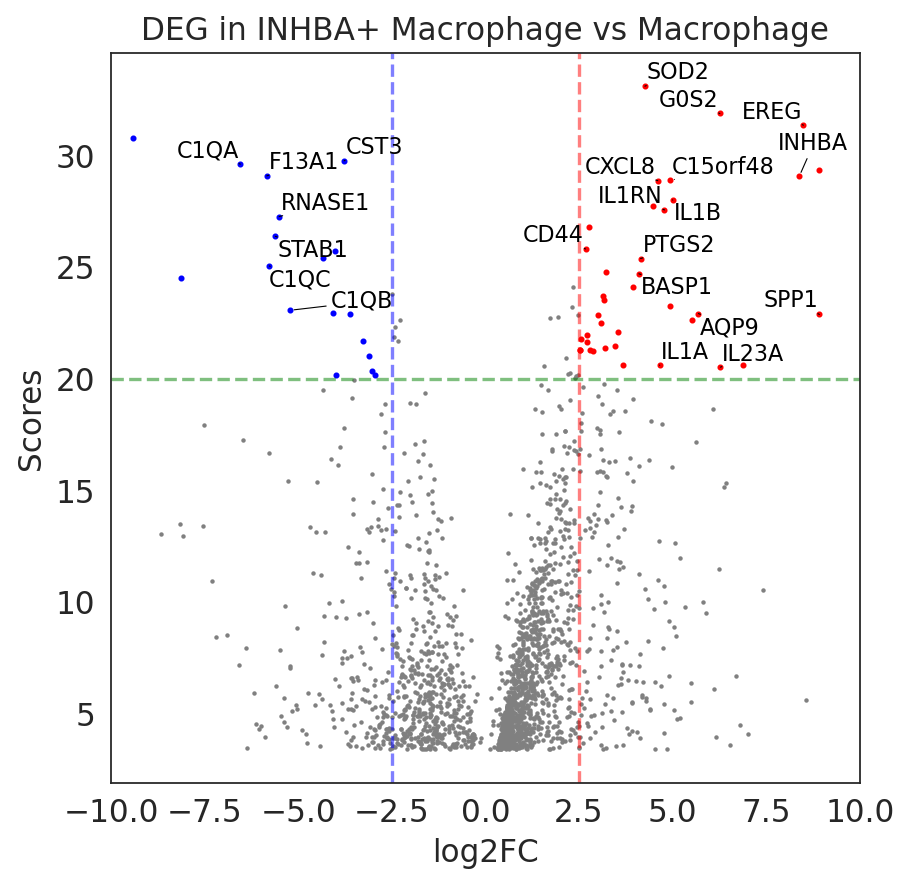

In [11]:
plt.figure(figsize=(6, 6))

macro_double_gene_rank_df = sc.get.rank_genes_groups_df(adata_immu, group='INHBA+ Macrophage', pval_cutoff=0.01, key='rank_genes_groups_inhba_macrophage_vs_macrophage')
macro_double_gene_rank_df['scores'] = np.abs(macro_double_gene_rank_df['scores'])
plt.scatter(x=macro_double_gene_rank_df['logfoldchanges'],y=macro_double_gene_rank_df['scores'], s=1, color='grey')
plt.xlim(-10,10)

down = macro_double_gene_rank_df[(macro_double_gene_rank_df['logfoldchanges']<=-2.5)&(macro_double_gene_rank_df['scores']>=20)]
up = macro_double_gene_rank_df[(macro_double_gene_rank_df['logfoldchanges']>=2.5)&(macro_double_gene_rank_df['scores']>=20)]

plt.scatter(x=down['logfoldchanges'],y=down['scores'],s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['logfoldchanges'],y=up['scores'],s=3,label="Up-regulated",color="red")

genes_to_plot = ['SOD2', 'G0S2', 'IL1RN', 'C15orf48', 'INHBA', 'CXCL8', 'IL1B',
                 'EREG', 'PTGS2', 'CD44', 'BASP1', 'AQP9', 'IL1B', 'IL1A', 'IL23A', 'SPP1', 'CXCL8'
                 # down
                'SEPP1', 'C1QA', 'C1QB', 'C1QC', 'CST3', 'F13A1', 'RNASE1', 'STAB1']

texts=[]

for i,r in up.iterrows():
    if r['logfoldchanges'] < 10 and r['names'] in genes_to_plot:
        # print(r['logfoldchanges'],r['scores'],r['names'])
        texts.append(plt.text(r['logfoldchanges'],r['scores'],r['names'],fontsize=10, color='black'))

for i,r in down.iterrows():
    if r['logfoldchanges'] > -10 and r['names'] in genes_to_plot:
        # print(r['logfoldchanges'],r['scores'],r['names'])
        texts.append(plt.text(r['logfoldchanges'],r['scores'],r['names'],fontsize=10, color='black'))

adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xlabel("log2FC")
plt.ylabel("Scores")
plt.axvline(x=2.5, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=-2.5, color='b', linestyle='--', alpha=0.5)
plt.axhline(y=20, color='g', linestyle='--', alpha=0.5)
plt.title("DEG in INHBA+ Macrophage vs Macrophage")
plt.savefig("figures/fig4_2/DEG_INHBA_Macrophage_vs_Macrophage.pdf")

### PPP neutrophil deg

In [13]:
# gene_list = list(adata_immu.uns['rank_genes_groups']['names']['Lesion'])
sc.tl.rank_genes_groups(adata_immu, 'leiden', method='wilcoxon', n_genes=2000, use_raw=True, groups=['PPP neutrophil'], tie_correct=True)
gene_list = list(sc.get.rank_genes_groups_df(adata_immu, group='PPP neutrophil', pval_cutoff=0.01, log2fc_min=1).names)

up_enr_bg = gp.enrichr(gene_list=gene_list,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='human',
                 outdir=None, # don't write to disk
                )

# up_enr_bg.results = up_enr_bg.results.sort_values(by='Odds Ratio', ascending=False)
up_enr_bg.results

sns.set_theme(style="white")
up_enr_bg.results['plot_size'] = -np.log10(up_enr_bg.results['Adjusted P-value'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:23)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


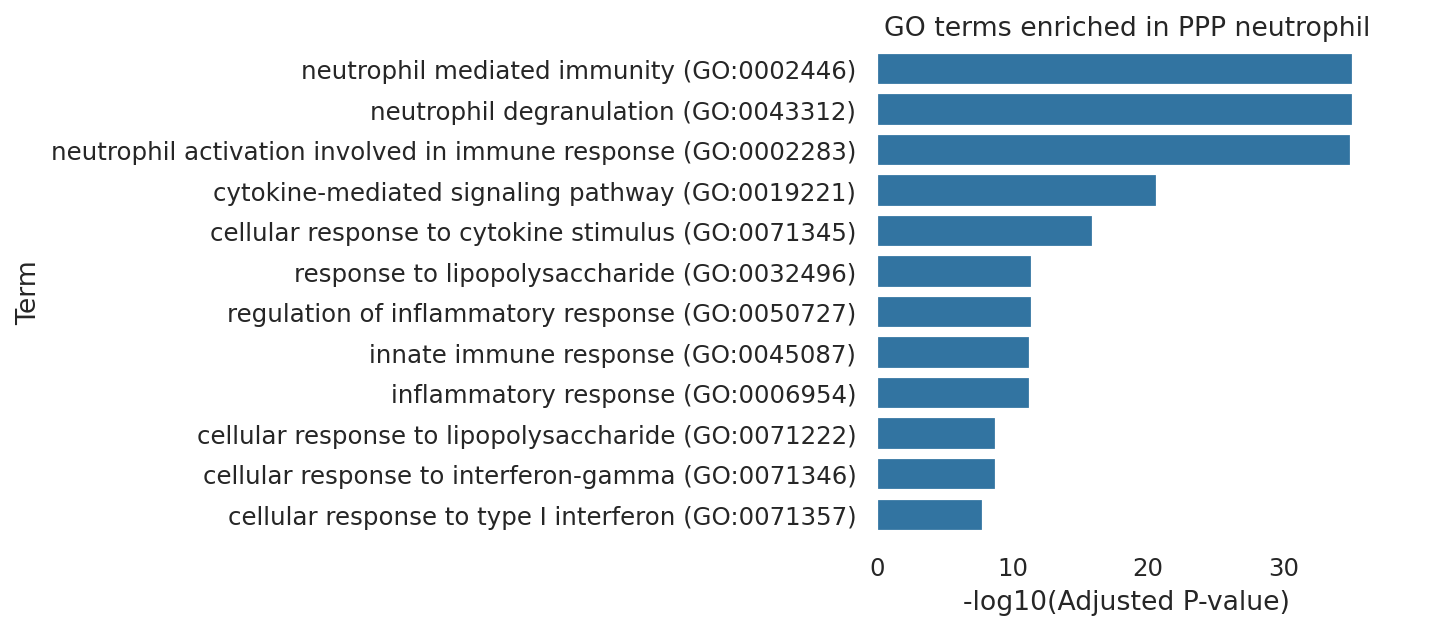

In [14]:
with plt.rc_context({'figure.figsize': (4, 4)}):
    sns.barplot(data=up_enr_bg.results.head(12), y='Term', x='plot_size', color='#1f77b4')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    plt.title('GO terms enriched in PPP neutrophil')
    plt.xlabel('-log10(Adjusted P-value)')
    sns.despine(left=True, bottom=True)
    plt.savefig('figures/fig4_2/PPP_neutrophil_GO_BP.pdf', bbox_inches='tight')

### Matrixplot

Storing dendrogram info using `.uns['dendrogram_leiden']`


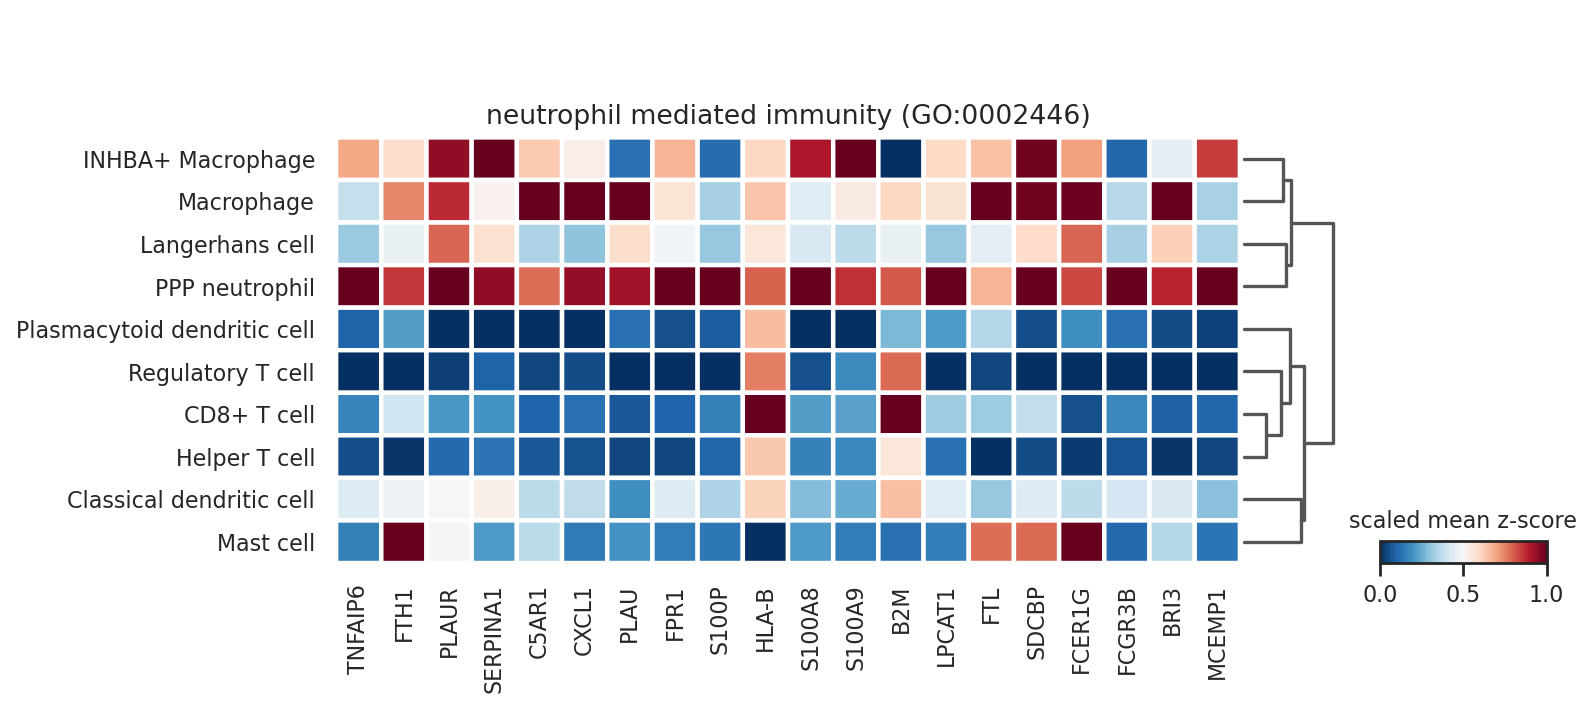

In [15]:
sc.tl.dendrogram(adata_immu, groupby='leiden', use_rep='X_pca', n_pcs=30)

tnf_alpha_nf_kb = up_enr_bg.results[up_enr_bg.results.Term == 'neutrophil mediated immunity (GO:0002446)'].Genes.values[0].split(';')
ppp_neut_plot_gene_list = [x for x in gene_list if x in tnf_alpha_nf_kb]
with plt.rc_context({'figure.figsize': (12, 6)}):
    ax = sc.pl.matrixplot(adata_immu, ppp_neut_plot_gene_list[:20], 'leiden', dendrogram=True, use_raw=False, return_fig=True,
                    standard_scale='var', colorbar_title='scaled mean z-score', show=False, linewidths=0.1).style(cmap='RdBu_r', edge_color='white', edge_lw=2).get_axes()
    ax['mainplot_ax'].set_title('neutrophil mediated immunity (GO:0002446)')
    # remove edge 
    ax['mainplot_ax']
    ax['mainplot_ax'].spines['left'].set_visible(False)
    ax['mainplot_ax'].spines['bottom'].set_visible(False)
    ax['mainplot_ax'].spines['top'].set_visible(False)
    ax['mainplot_ax'].spines['right'].set_visible(False)
    plt.savefig('figures/fig4_2/PPP_neutrophil_GO_0002446.pdf', bbox_inches='tight')